# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [126]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from bizdays import Calendar
from matplotlib.ticker import MaxNLocator

cal = Calendar.load("ANBIMA")
maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [127]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [128]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [129]:
data = data[data["mdate"] <= pd.Period("2023-07")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [130]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [131]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [132]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [133]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [134]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [135]:
dias_uteis = 5

copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates = copom_dates[copom_dates['COPOM_date'] >= pd.Period("2001-01-01").to_timestamp()]
copom_dates['COPOM_date'] = cal.offset(copom_dates['COPOM_date'],0)
instrumento = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],dias_uteis),'q':0})
copom_dates = pd.concat([copom_dates, instrumento])
copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")


Drop unnecessary columns

In [136]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [137]:
temp_data = pd.read_pickle("temp.pkl")

In [138]:
copom_dates.sort_values("COPOM_date")

,COPOM_date,q,mdate
54,2001-01-17,1,2001-01
0,2001-01-24,0,2001-01
55,2001-02-14,1,2001-02
1,2001-02-21,0,2001-02
56,2001-03-21,1,2001-03
...,...,...,...
197,2023-02-08,0,2023-02
252,2023-03-22,1,2023-03
198,2023-03-29,0,2023-03
253,2023-05-03,1,2023-05


Merge the two DataFrames on the 'date' column

In [139]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [140]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [141]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2001-01-17,16.0486,-0.1206,2001-01-17,1,2001-01
1,2001-01-24,15.6766,-0.0465,2001-01-24,0,2001-01
2,2001-02-14,15.8076,-0.0080,2001-02-14,1,2001-02
3,2001-02-21,16.5406,0.2347,2001-02-21,0,2001-02
4,2001-03-21,18.2104,0.5213,2001-03-21,1,2001-03


Save the merged DataFrame to a new file

In [142]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [143]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [144]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [145]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [146]:
yield_data.head()

,date,mdate,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
0,2006-01-02,2006-01,16.603599,16.069818,15.813602,15.678468,15.596889,15.542471,15.503599,15.474444,...,15.348109,15.344575,15.341349,15.338391,15.335670,15.333158,15.330832,15.328673,15.326662,15.324786
1,2006-01-03,2006-01,16.594441,16.064808,15.800027,15.659489,15.574586,15.517946,15.477487,15.447142,...,15.315649,15.311971,15.308612,15.305534,15.302702,15.300088,15.297667,15.295419,15.293326,15.291373
2,2006-01-04,2006-01,16.567391,15.906773,15.597463,15.460412,15.396983,15.364394,15.345285,15.332609,...,15.283329,15.281973,15.280736,15.279601,15.278557,15.277594,15.276701,15.275873,15.275102,15.274382
3,2006-01-05,2006-01,16.564073,15.900342,15.579618,15.436914,15.374310,15.346010,15.332288,15.324890,...,15.304758,15.304254,15.303794,15.303372,15.302984,15.302626,15.302294,15.301986,15.301699,15.301432
4,2006-01-06,2006-01,16.537489,15.886892,15.571989,15.437172,15.385606,15.369317,15.366877,15.369324,...,15.398403,15.399311,15.400141,15.400901,15.401600,15.402245,15.402843,15.403398,15.403915,15.404397


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [ ]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [148]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.019636,0.018121,0.016738,0.015471,0.014305,0.013229,0.012232,0.011307,0.010445,0.009641
1,2006-01-25,16.0479,0.0761,2006-01-25,0,2006-01,16.047587,15.634306,15.433807,15.324559,...,0.013354,0.013478,0.013591,0.013695,0.013790,0.013878,0.013960,0.014035,0.014106,0.014171
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.166905,0.166399,0.165938,0.165514,0.165125,0.164765,0.164433,0.164123,0.163836,0.163567
3,2006-03-15,14.8818,-0.1620,2006-03-15,0,2006-03,14.900187,14.479089,14.285118,14.159978,...,-0.562163,-0.566420,-0.570307,-0.573870,-0.577148,-0.580174,-0.582976,-0.585578,-0.588000,-0.590261
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.799602,0.821436,0.841429,0.859793,0.876714,0.892348,0.906836,0.920295,0.932831,0.944534


### Step 1 - 2SLS

In [149]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [150]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.4959
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4941
No. Observations:                 278   F-statistic:                    6.5092
Date:                Thu, Sep 21 2023   P-value (F-stat)                0.0107
Time:                        10:27:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0012     0.0038    -0.3252     0.7450     -0.0086      0.0062
dgs_d          0.3270     0.1282     2.5513     0.01

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY10_d   R-squared:                      0.2278
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2250
No. Observations:                 278   F-statistic:                    1.1155
Date:                Thu, Sep 21 2023   P-value (F-stat)                0.2909
Time:                        10:27:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0043     0.0089    -0.4811     0.6304     -0.0217      0.0131
dgs_d          0.3699     0.3502     1.0562     0.29

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY19_d   R-squared:                      0.1881
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1851
No. Observations:                 278   F-statistic:                    0.8109
Date:                Thu, Sep 21 2023   P-value (F-stat)                0.3678
Time:                        10:27:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0065     0.0098    -0.6616     0.5082     -0.0257      0.0127
dgs_d          0.3367     0.3739     0.9005     0.36

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY30_d   R-squared:                      0.1586
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1555
No. Observations:                 278   F-statistic:                    0.6822
Date:                Thu, Sep 21 2023   P-value (F-stat)                0.4088
Time:                        10:27:35   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0074     0.0110    -0.6741     0.5002     -0.0290      0.0142
dgs_d          0.3261     0.3949     0.8260     0.40

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat21,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.334455,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144
1,2006-01-25,16.0479,0.0761,2006-01-25,0,2006-01,16.047587,15.634306,15.433807,15.324559,...,0.334455,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.334455,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144
3,2006-03-15,14.8818,-0.1620,2006-03-15,0,2006-03,14.900187,14.479089,14.285118,14.159978,...,0.334455,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.334455,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144


### Step 2 - Fama and MacBeth

In [151]:
data_complete = data_complete.loc[~mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY01_d"):data_complete.columns.get_loc("SVENY30_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat01"):data_complete.columns.get_loc("beta_hat30") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

In [152]:
data_complete

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,0.330972
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,0.192894
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,-3.403720
6,2006-05-31,15.5581,0.2824,2006-05-31,1,2006-05,15.650954,16.233859,16.492478,16.647477,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,-0.079459
8,2006-07-19,14.5308,-0.1601,2006-07-19,1,2006-07,14.561411,14.930508,15.213151,15.430707,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,0.104359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2022-10-26,13.1619,0.0286,2022-10-26,1,2022-10,13.161910,12.180024,11.901106,11.907697,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,0.286883
270,2022-12-07,13.8006,-0.1457,2022-12-07,1,2022-12,13.800637,13.178937,12.866504,12.775328,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,-0.385524
272,2023-02-01,13.4606,0.0562,2023-02-01,1,2023-02,13.460675,12.969535,12.914477,12.986268,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,-0.030857
274,2023-03-22,12.6745,-0.0090,2023-03-22,1,2023-03,12.674533,12.075047,12.236598,12.516870,...,0.333416,0.332419,0.331455,0.330517,0.329602,0.328709,0.327835,0.32698,0.326144,0.017182


### Renormalization

In [153]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


In [154]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              3.765
Date:                Thu, 21 Sep 2023   Prob (F-statistic):                      0.0544
Time:                        10:27:35   Log-Likelihood:                          51.139
No. Observations:                 139   AIC:                                     -100.3
Df Residuals:                     138   BIC:                                     -97.34
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [155]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2023-06-30")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_complete[['mdate', 'BRW_daily']]

columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')
data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2006-01   0.015625
1    2006-02   0.000000
2    2006-03   0.009107
3    2006-04  -0.160691
4    2006-05  -0.003751
..       ...        ...
205  2023-02  -0.001457
206  2023-03   0.000811
207  2023-04   0.000000
208  2023-05   0.007063
209  2023-06   0.000000

[210 rows x 2 columns]


C:\Users\Alysson\AppData\Local\Temp\ipykernel_13084\2375401341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')


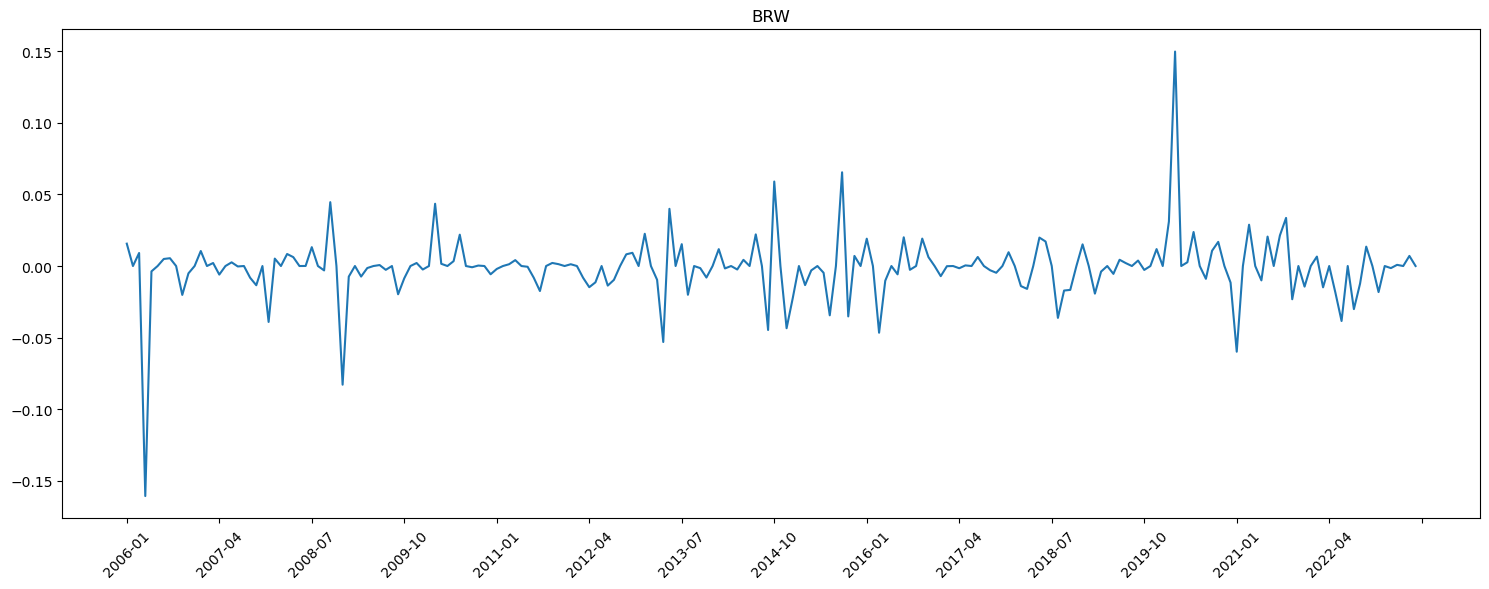

In [156]:
# Converter valores do tipo Period para datetime
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [159]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)

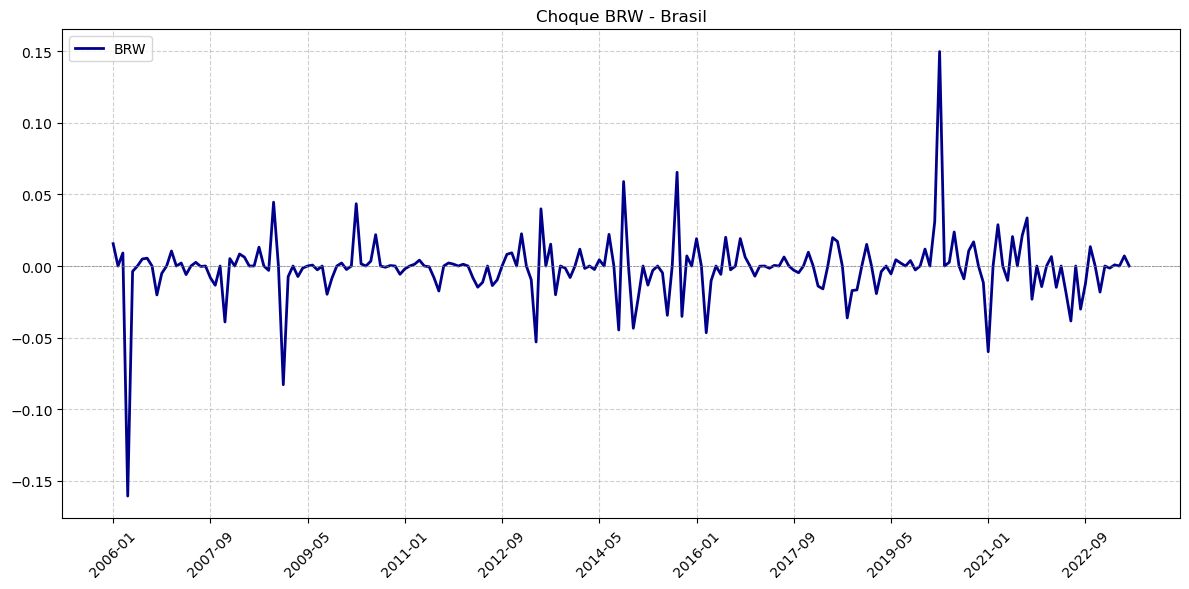

In [158]:

# Seu código para criar os dados (mdate_values, new_shock_values) aqui

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.plot(mdate_values, new_shock_values, color='darkblue', linewidth=2, label='BRW')
plt.title("Choque BRW - Brasil")
#plt.xlabel("Data")
#plt.ylabel("Valor do Choque")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')

# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exibindo o gráfico
plt.show()
